#  PROJECT - MATH&ML-13. Временные ряды. Часть II. 
# 1. Статистические модели прогнозирования. Практика

**Задания для проекта**

Итак, здесь вы начинаете работу над своим небольшим проектом. Напоминаем — работать нужно с [данными по ВВП Ганы](https://lms-cdn.skillfactory.ru/assets/courseware/v1/cf3fb9ca311981f5cc6b6f0a40621388/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/ghana_gdp.zip). Выполняйте все задания проекта в одном Jupyter-ноутбуке.

1. Прочитайте исходный файл с данными. Визуализируйте исходный временной ряд, сделайте первичные выводы о присутствии компонент тренда и сезонности в ряде.
    
    Отложите последние три года из датасета как тестовую выборку для оценки результатов предсказания.

2. Постройте график скользящего среднего, проанализируйте результат. Для построения MA используйте метод rolling(), который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.

Пример:
```py 
train_df.spx.rolling(window=2).mean().
```
Визуализируйте исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравните графики между собой и сделайте выводы.

3. С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA.

**Примечание**. Если ваш ряд является нестационарным, дифференцируйте его до тех пор, пока он не станет таковым. Количество дифференцирований, необходимых для сведения ряда к стационарному, будет вашим параметром d для модели ARIMA.

Параметры p и q выберите по коррелограммам ACF и PACF.

**Примечание**. Помните, что параметры p и q для ARMA/ARIMA определяются из коррелограмм стационарного ряда. То есть, если ваш изначальный временной ряд не являлся стационарным, то коррелограммы строятся для разностей того порядка, которые являются стационарными.

Постройте модель ARMA/ARIMA для прогнозирования поведения временного ряда.

Также постройте несколько моделей с параметрами, ближайшими к найденным p и q, и сравните коэффициент AIC (или подберите наилучшие параметры с помощью пакета pmdarima, как в скринкасте).

4. Постройте модель с наилучшими параметрами и выполните предсказание для отложенной тестовой выборки (последние три года).
5. Отобразите результат графически — постройте графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза.
6. Сделайте выводы по полученным результатам.

## 1.1. Импорт библиотек, загрузка данных, визуализация исходного временного ряда, первичные выводы

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

from arch import arch_model
from prophet import Prophet

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
data = pd.read_csv("data/ghana_gdp.csv", parse_dates=["year"], index_col=["year"])
data.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


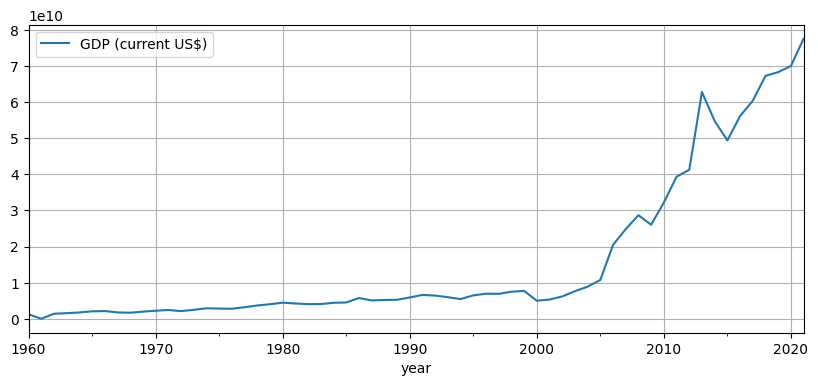

In [3]:
plt.rcParams["figure.figsize"] = 10, 4

data.plot()
plt.grid()
plt.show()

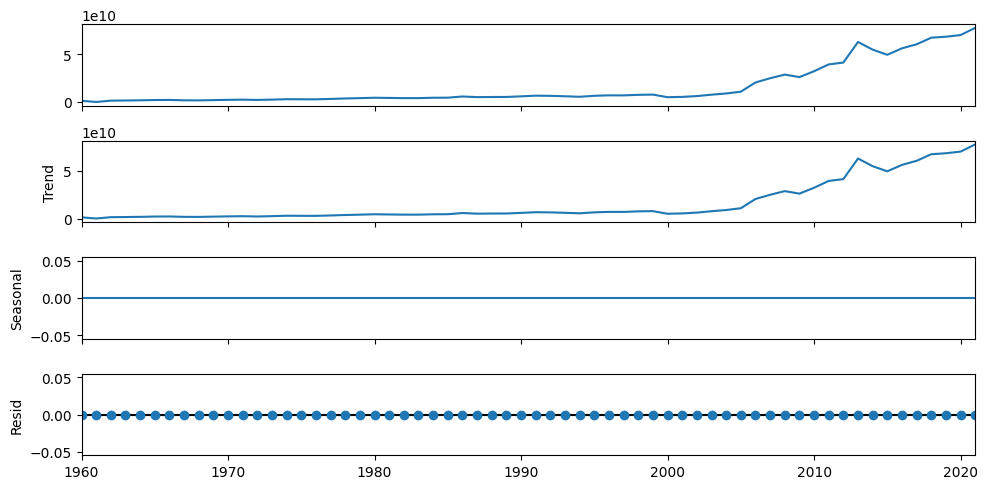

In [4]:
plt.rcParams["figure.figsize"] = 10, 5

result = seasonal_decompose(data)
result.plot()
plt.show()

Видим положительный тренд после 2005 года

Не наблюдается сезонности

Особо нет шума

In [5]:
train_df = data['GDP (current US$)'][:len(data)-3]
test_df = data['GDP (current US$)'][len(data)-3:]
train_df.shape, test_df.shape

((59,), (3,))

## 1.2. График скользящего среднего, анализ результата

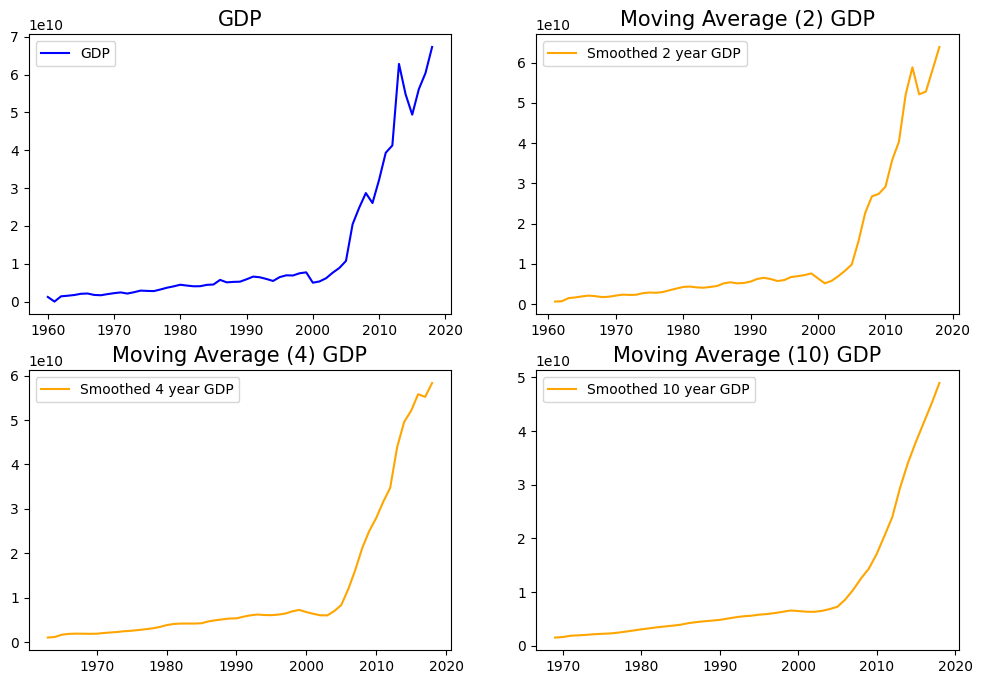

In [6]:
plt.rcParams["figure.figsize"] = 12, 8

fig, ax = plt.subplots(2, 2)

ax[0, 0].plot(train_df, color="blue", label="GDP")
ax[0, 0].set_title("GDP", size=15)
ax[0, 0].legend()

# Окно в 2 года (Window = 2)
ax[0, 1].plot(
    train_df.rolling(window=2).mean(),
    color="orange",
    label="Smoothed 2 year GDP",
)

ax[0, 1].set_title("Moving Average (2) GDP", size=15)
ax[0, 1].legend()

# Окно в 4 лет (Window = 4)
ax[1, 0].plot(
    train_df.rolling(window=4).mean(),
    color="orange",
    label="Smoothed 4 year GDP",
)
ax[1, 0].set_title("Moving Average (4) GDP", size=15)
ax[1, 0].legend()

# Окно в 10 лет (Window = 10)
ax[1, 1].plot(
    train_df.rolling(window=10).mean(),
    color="orange",
    label="Smoothed 10 year GDP",
)

ax[1, 1].set_title("Moving Average (10) GDP", size=15)
ax[1, 1].legend()

plt.show()

* **Исходный временной ряд (синий, GDP)** показывает резкие скачки и флуктуации, особенно после 2000-х годов. Это затрудняет выявление долгосрочного тренда.

* **Скользящее среднее с малым окном (2 года)** почти повторяет исходный ряд, лишь слегка сглаживая шум. Оно полезно для сглаживания мелких колебаний, но сохраняет общую «неровность».

* **Скользящее среднее с окном 4 года** сильнее сглаживает данные: локальные всплески и падения становятся менее заметны, зато отчётливо виден общий тренд роста.

* **Скользящее среднее с окном 10 лет** максимально «выпрямляет» график: исчезают краткосрочные колебания, остаётся только долгосрочный рост. Но при этом теряется информация о локальных изменениях (например, кризисы или быстрые подъемы).

**Выводы**:

1. Скользящее среднее эффективно убирает шум и позволяет лучше рассматривать **общий тренд** временного ряда.
2. Чем **шире окно**, тем сильнее сглаживание:

   * малое окно (2) → хорошо видно краткосрочные изменения;
   * среднее окно (4) → баланс между трендом и колебаниями;
   * большое окно (10) → только долгосрочный тренд, без деталей.
3. Для анализа экономических временных рядов, таких как GDP, полезно использовать **несколько значений окна**: маленькие — для локальных циклов, большие — для глобального тренда.

ACF быстро затухает → ряд почти без сезонности, можно брать малое окно (2–3).

## 1.3. Оценка стационарности, подбор наилучших параметров и построение модели ARMA/ARIMA для прогнозирования поведения временного ряда

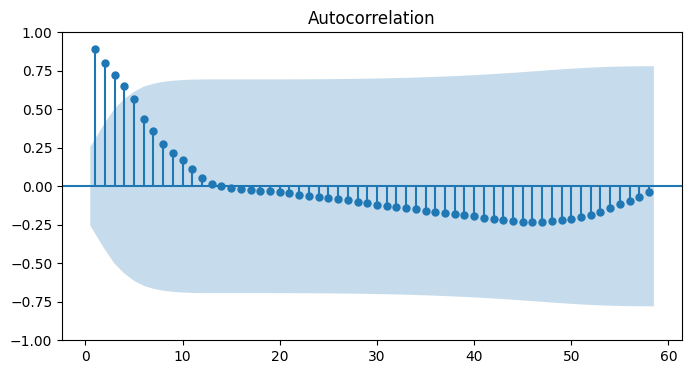

In [7]:
plt.rcParams["figure.figsize"] = 8, 4
plot_acf(train_df, lags=58, zero=False)
plt.show()

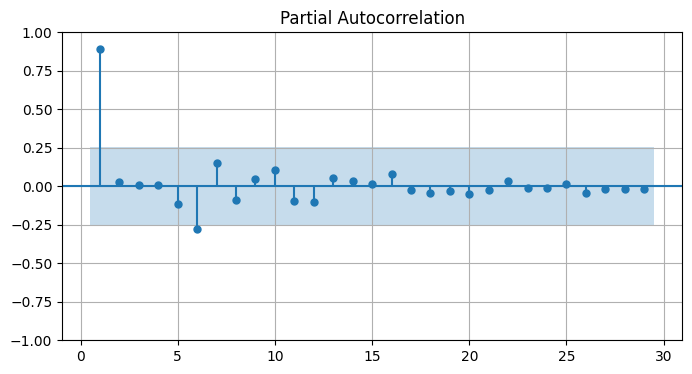

In [8]:
plt.rcParams["figure.figsize"] = 8, 4
plot_pacf(train_df, lags=29, method="ywm", zero=False)
plt.grid()
plt.show()

In [9]:
test1 = adfuller(train_df)
print("adf: ", test1[0])
print("p-value: ", test1[1])
print("Critical values: ", test1[4])
if test1[0] > test1[4]["5%"]:
    print("ряд нестационарен")
else:
    print("ряд стационарен")

adf:  0.6529066974885405
p-value:  0.9888496277665573
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


In [10]:
def plot_acf_pacf_check_adf(series):
    plt.rcParams["figure.figsize"] = 12, 4

    fig, axes = plt.subplots(1, 2)

    plot_acf(series, ax=axes[0], lags=50)
    plot_pacf(series, ax=axes[1], lags=25, method="ywm")
    plt.show()
    
    test1 = adfuller(series)
    print("adf: ", test1[0])
    print("p-value: ", test1[1])
    print("Critical values: ", test1[4])
    if test1[0] > test1[4]["5%"]:
        print("ряд нестационарен")
    else:
        print("ряд стационарен")

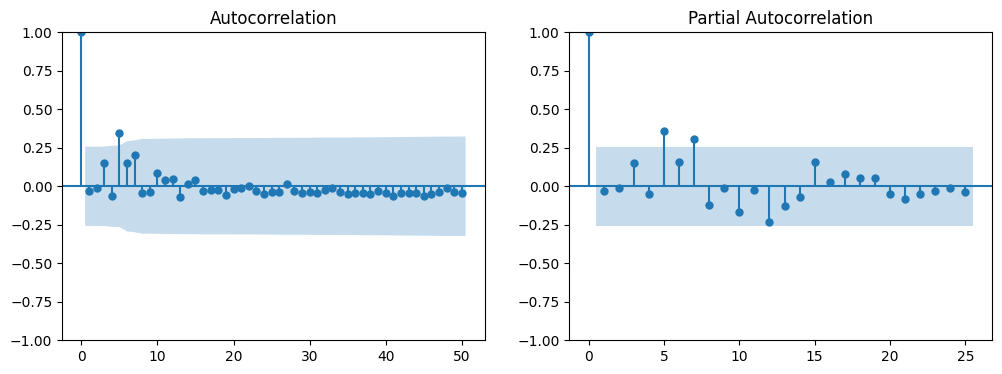

adf:  -1.670248303832082
p-value:  0.44650293297138693
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
ряд нестационарен


In [11]:
# строим интегрированный ряд первого порядка
plot_acf_pacf_check_adf(train_df.diff().dropna())

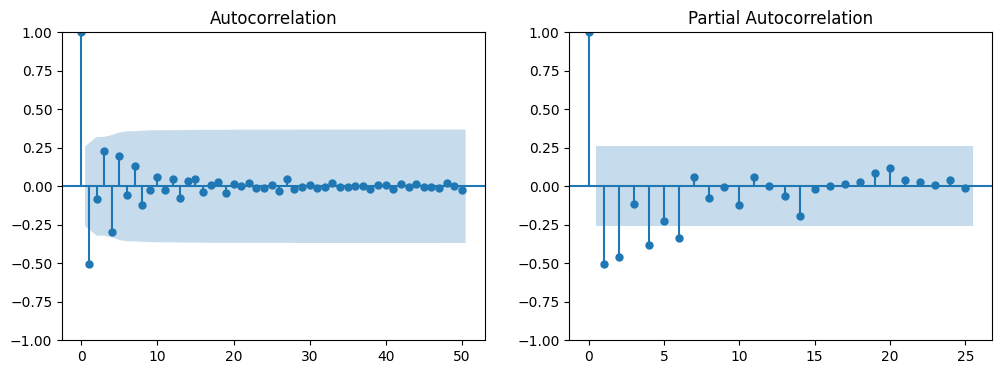

adf:  -2.6408690561284924
p-value:  0.08484116917837625
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд нестационарен


In [12]:
# строим интегрированный ряд второго порядка
plot_acf_pacf_check_adf(train_df.diff().dropna().diff().dropna())

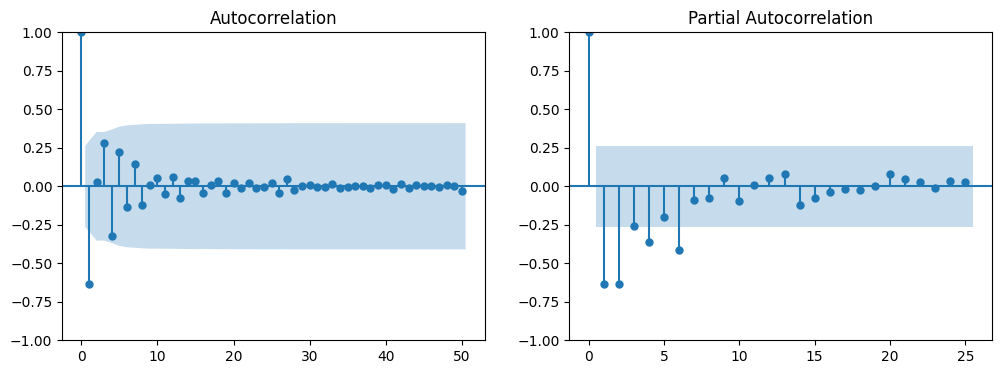

adf:  -4.779623784828569
p-value:  5.948327640223947e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд стационарен


In [13]:
# строим интегрированный ряд третьего порядка
plot_acf_pacf_check_adf(train_df.diff().dropna().diff().dropna().diff().dropna())

Получили стационарный ряд при разности 3 порядка

<img src="https://lms-cdn.skillfactory.ru/assets/courseware/v1/0aac71ca90665c4bfaf4a3d80d869421/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/MATHML_md13_3_7.png" alt="" width="700" align="center" />


- Изначальный ряд не стационарен.
- Экзогенные переменные не используются.
- Учитывать сезонность нет необходимости.
- Следовательно, выбираем модель **ARIMA**

In [14]:
d = 3 # порядок интегрирования
p = 6 # последний значимый лаг на графике частичной корреляции
q = 1 # последний значимый лаг на автокорреляции

In [15]:
arima_model = ARIMA(train_df.dropna(), order=(p, d, q))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(6, 3, 1)   Log Likelihood               -1306.570
Date:                Fri, 05 Sep 2025   AIC                           2629.140
Time:                        18:20:10   BIC                           2645.343
Sample:                    01-01-1960   HQIC                          2635.422
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3723      0.072    -19.184      0.000      -1.513      -1.232
ar.L2         -1.7074      0.156    -10.942      0.000      -2.013      -1.402
ar.L3         -1.5726      0.205     -7.659      0.000      -1.975      -1.170
ar.L4         -1.6483      0.141    -11.715      0.000      -1.924      -1.373
ar.L5         -1.2769      0.159     -8.021      0.000      -1.589      -0.965
ar.L6         -0.8853      0.148     -5.975      0.000      -1.176      -0.595
ma.L1         -0.5919      0.104     -5.673      0.000      -0.796      -0.387
sigma2      8.567e+18   3.66e-20   2.34e+38      0.000    8.57e+18    8.57e+18
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                73.04
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):              76.70   Skew:                            -0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.62e+53. Standard errors may be unstable.
"""

In [16]:
smodel = pm.auto_arima(
    train_df,
    start_p=4, max_p=10,   # перебор p
    start_q=0, max_q=5,   # перебор q
    d=3,                  # порядок интегрирования
    start_P=0, max_P=5,   # сезонный p
    start_Q=0, max_Q=5,   # сезонный q
    D=1,                  # сезонная дифференциация
    test="adf",           # проверка на стационарность
    information_criterion="aic", # критерий выбора
    error_action="ignore",
    n_jobs=-1,            # распараллеливание
    trace=True            # выводим процесс
)

print(smodel.summary())

Performing stepwise search to minimize aic
 ARIMA(4,3,0)(0,0,0)[0]             : AIC=2663.754, Time=0.14 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.956, Time=0.02 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.192, Time=0.01 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.371, Time=0.02 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.883, Time=0.02 sec
 ARIMA(5,3,0)(0,0,0)[0]             : AIC=2662.197, Time=0.05 sec
 ARIMA(6,3,0)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(5,3,1)(0,0,0)[0]             : AIC=2646.870, Time=0.08 sec
 ARIMA(4,3,1)(0,0,0)[0]             : AIC=2647.936, Time=0.06 sec
 ARIMA(6,3,1)(0,0,0)[0]             : AIC=2629.140, Time=0.18 sec
 ARIMA(7,3,1)(0,0,0)[0]             : AIC=2626.991, Time=0.23 sec
 ARIMA(7,3,0)(0,0,0)[0]             : AIC=2632.892, Time=0.19 sec
 ARIMA(8,3,1)(0,0,0)[0]             : AIC=2629.149, Time=0.36 sec
 ARIMA(7,3,2)(0,0,0)[0]             : AIC=inf, Time=0.30 sec
 ARIMA(6,3,2)(0,0,0)[0]             : AIC=i

## 1.4. Построение модели с наилучшими параметрами и получение предсказания для отложенной тестовой выборки (последние три года).

In [17]:
smodel.order

(7, 3, 1)

In [18]:
smodel.seasonal_order

(0, 0, 0, 0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:               SARIMAX(7, 3, 1)   Log Likelihood               -1304.496
Date:                Fri, 05 Sep 2025   AIC                           2626.991
Time:                        18:20:14   BIC                           2645.219
Sample:                    01-01-1960   HQIC                          2634.058
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0086      0.104     -9.655      0.000      -1.213      -0.804
ar.L2         -1.0877      0.227     -4.781      0.000      -1.534      -0.642
ar.L3         -0.7461      0.279     -2.676      0.007      -1.293      -0.200
ar.L4         -0.8498      0.251     -3.382      0.001      -1.342      -0.357
ar.L5         -0.4889      0.248     -1.968      0.049      -0.976      -0.002
ar.L6         -0.1975      0.257     -0.769      0.442      -0.701       0.306
ar.L7          0.4571      0.175      2.609      0.009       0.114       0.801
ma.L1         -0.9846      0.109     -9.040      0.000      -1.198      -0.771
sigma2      8.556e+18        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                78.81
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):              68.67   Skew:                             0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.05e+53. Standard errors may be unstable.
"""

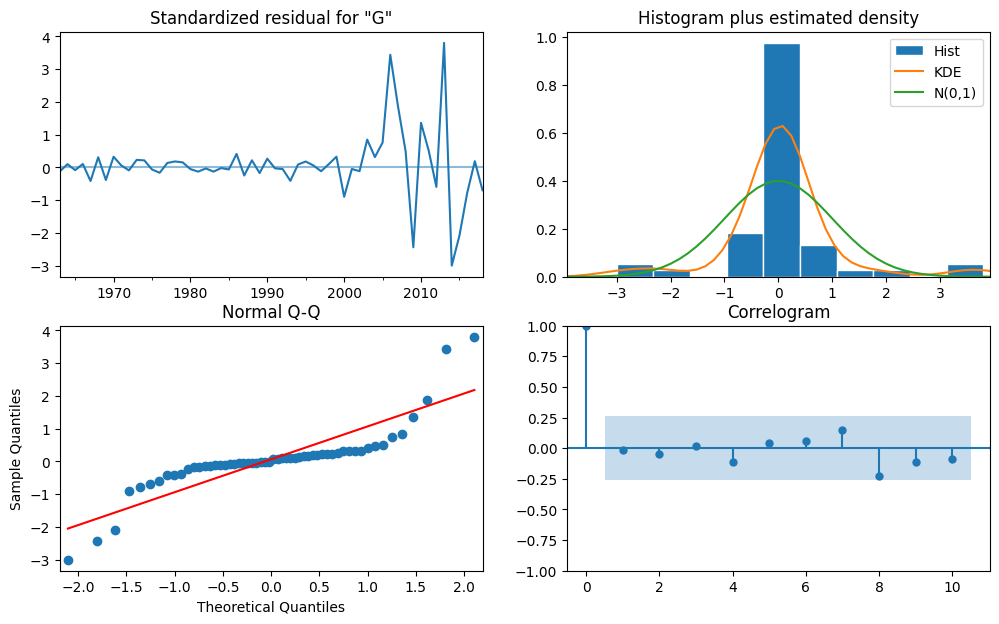

In [19]:
# Разделение на train/test
train = data.iloc[:-3]
test = data.iloc[-3:]

Final_model = SARIMAX(train['GDP (current US$)'],
                    order=smodel.order,
                    seasonal_order=smodel.seasonal_order)
Final_output = Final_model.fit(disp=False)

# Displaying the model summary and diagnostics
plt.rcParams["figure.figsize"] = 12, 7
display(Final_output.summary());
Final_output.plot_diagnostics();

## 1.5. Отображение результата графически — графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза.

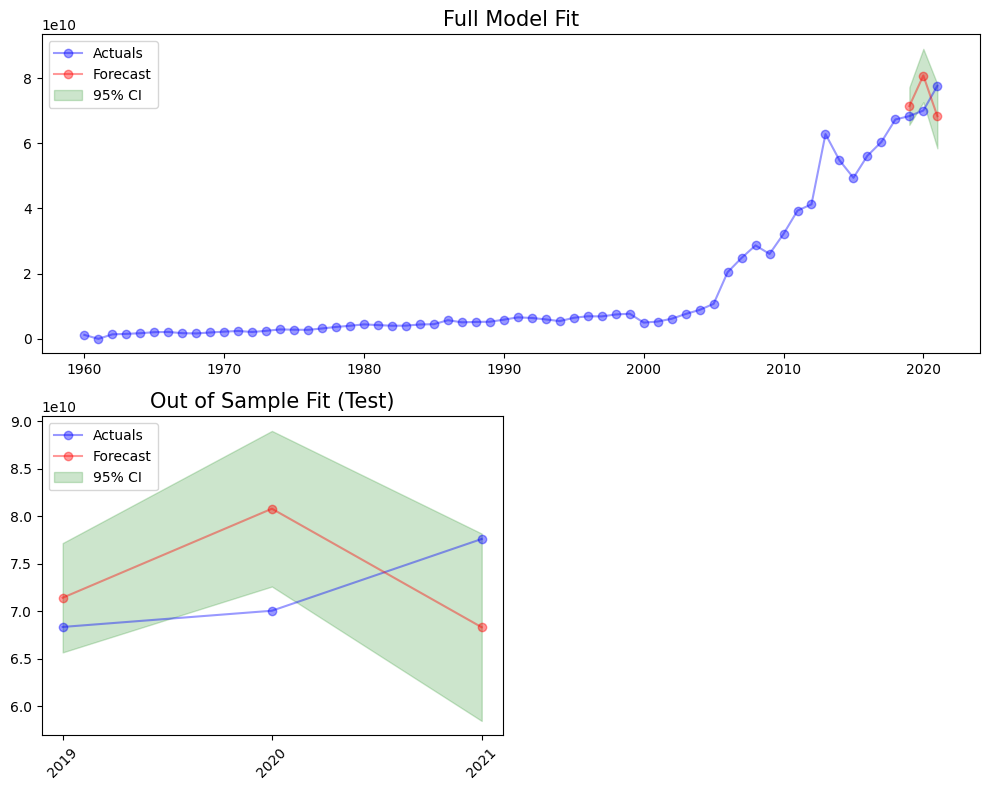

In [20]:
# Прогноз на тест
forecast = Final_output.get_forecast(steps=len(test))
forecast_conf = forecast.conf_int(alpha=0.05)

# Собираем DataFrame с предсказаниями
pred_df = pd.DataFrame({
    "actuals": data["GDP (current US$)"],
    "model_preds": forecast.predicted_mean,
    "model_preds_lower": forecast_conf.iloc[:, 0],
    "model_preds_upper": forecast_conf.iloc[:, 1]
})

# Визуализация
plt.rcParams["figure.figsize"] = (10, 8)

# --- График 1: полный ряд ---
plt.subplot(2, 1, 1)
plt.plot(pred_df["actuals"], color="blue", label="Actuals", alpha=0.4, marker='o')
plt.plot(pred_df["model_preds"], color="red", label="Forecast", alpha=0.4, marker='o')

plt.fill_between(
    forecast_conf.index,
    forecast_conf.iloc[:, 0],
    forecast_conf.iloc[:, 1],
    color="green",
    alpha=0.2,
    label="95% CI"
)
plt.title("Full Model Fit", size=15)
plt.legend()

# --- График 2: тестовый участок ---
plt.subplot(2, 2, 3)
plt.plot(test.index, test["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4, marker='o')
plt.plot(test.index, forecast.predicted_mean, color="red", label="Forecast", alpha=0.4, marker='o')
plt.fill_between(
    forecast_conf.index,
    forecast_conf.iloc[:, 0],
    forecast_conf.iloc[:, 1],
    color="green",
    alpha=0.2,
    label="95% CI"
)
plt.title("Out of Sample Fit (Test)", size=15)
plt.legend()

# Настройка оси X для годовых данных
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # каждая метка — год
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # отображать только год
plt.xticks(rotation=45)  # повернуть метки для читаемости

plt.tight_layout()
plt.show()

## 1.6. Выводы по полученным результатам

Наилучшая модель получилась с AIC = 2626.991 и параметрами SARIMAX(7, 3, 1). Стационарности достигли при третьей разности. Модель отметила волатильность, которая сильно увеличилась после примерно 2005 года (что видно на графике residuals), и предсказанные значения почти попадают в доверительный интервал 95%

# 2. Интерполяция и сэмплирование. Практика

**Задания для проекта**

1. Проверьте данные на наличие пропущенных дат. Помимо визуального способа, это можно сделать с помощью метода [DataFrame.asfreq()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.asfreq.html), передав в него параметр частоты, например ‘d’ — день, ‘m’ — месяц. Все алиасы для параметров частоты доступны [по ссылке](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timeseries-offset-aliases).
**Подсказка**
```py
df.asfreq(freq='AS')
```
2. Проверьте данные на наличие пропущенных значений (Series.isna().sum()).
3. Обратите внимание, что иногда пропуски в данных могут быть заполнены нулями. Сделайте проверку на наличие нулевых значений и в случае нахождения замените их на NaN. 

Воспользуйтесь кодом ниже:
```py
import numpy as np
df['GDP (current US$)'] = df['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)
```
4. Для заполнения пропусков выполните интерполяцию с использованием метода .interpolate().
**Подсказка**
```py
df['GDP (current US$)'].interpolate(method='linear')
```
5. Проверьте полученный ряд на стационарность, определите параметры модели (ARIMA/ARMA) и запустите модель.
6. Изменился ли AIC критерий построенной модели по сравнению с моделью на неинтерполированных данных? Сделайте вывод.

## 2.1. Проверка данных на пропуски дат

Empty DataFrame
Columns: [GDP (current US$)]
Index: []
(62, 1)


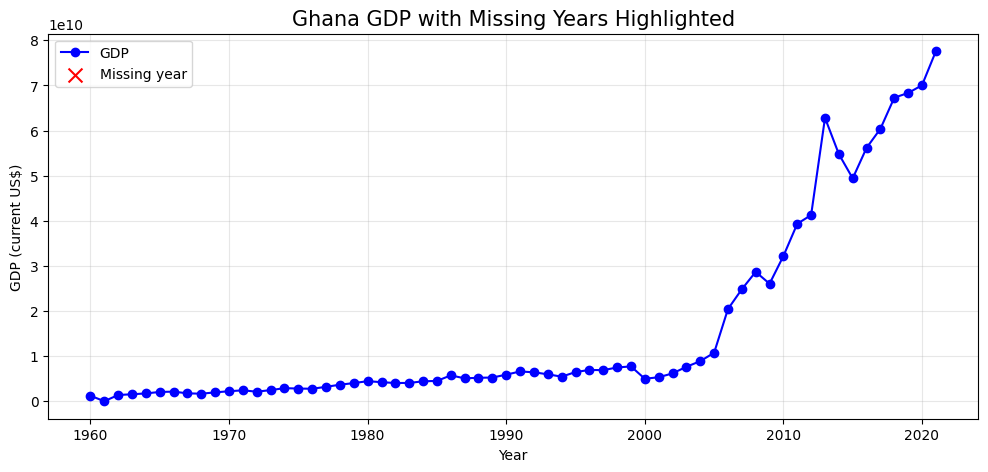

In [21]:
df_yearly = data.copy()

# Приводим к годовой частоте
df_yearly = df_yearly.asfreq('AS')

# Проверим, есть ли пропуски
missing = df_yearly[df_yearly.isna().any(axis=1)]
print(missing)
print(data.shape)

plt.figure(figsize=(12, 5))
plt.plot(df_yearly.index, df_yearly["GDP (current US$)"], marker='o', linestyle='-', color='blue', label="GDP")

# Отметим пропуски красными крестиками
plt.scatter(missing.index, [0]*len(missing), color='red', marker='x', s=100, label="Missing year")

plt.title("Ghana GDP with Missing Years Highlighted", size=15)
plt.xlabel("Year")
plt.ylabel("GDP (current US$)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Пропущенных дат этим методом не выявлено

## 2.2. Проверка данных на наличие пропусков

In [22]:
df_yearly["GDP (current US$)"].isna().sum()

0

Пропущенных значений нет

## 2.3. Проверка на пропуски, заполненные нулями

1


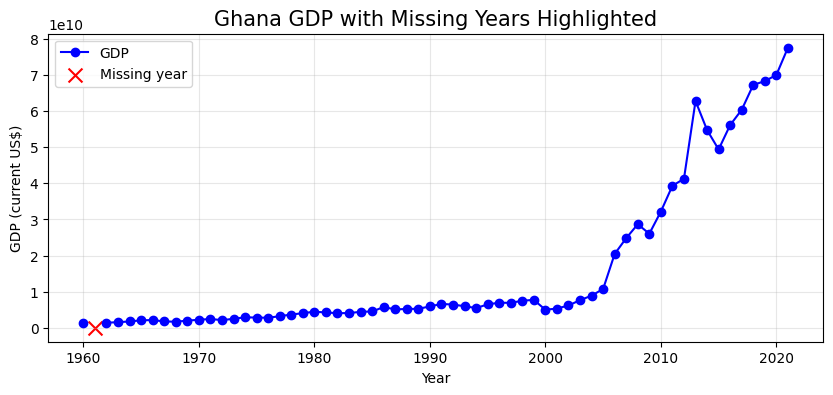

In [23]:
df_yearly['GDP (current US$)'] = df_yearly['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)

print(df_yearly["GDP (current US$)"].isna().sum())

missing = df_yearly[df_yearly.isna().any(axis=1)]

plt.figure(figsize=(10, 4))
plt.plot(df_yearly.index, df_yearly["GDP (current US$)"], marker='o', linestyle='-', color='blue', label="GDP")

# Отметим пропуски красными крестиками
plt.scatter(missing.index, [0]*len(missing), color='red', marker='x', s=100, label="Missing year")

plt.title("Ghana GDP with Missing Years Highlighted", size=15)
plt.xlabel("Year")
plt.ylabel("GDP (current US$)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Все таки было одно пропущенное значение, заполненное нулем

## 2.4. Заполнение пропусков интерполяцией методом .interpolate()

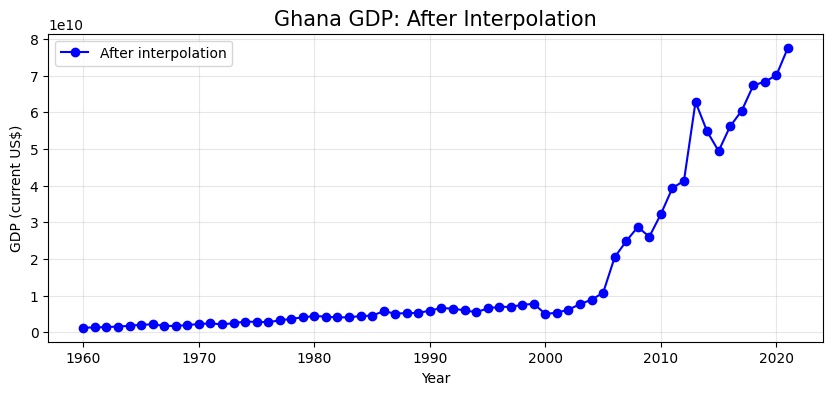

In [24]:
# Интерполяция
df_interp = df_yearly.copy()
df_interp['GDP (current US$)'] = df_interp['GDP (current US$)'].interpolate(method='linear')

# Визуализация до и после
plt.figure(figsize=(10, 4))

plt.plot(df_interp.index, df_interp['GDP (current US$)'], 
         marker='o', linestyle='-', color='blue', label="After interpolation")

plt.title("Ghana GDP: After Interpolation", size=15)
plt.xlabel("Year")
plt.ylabel("GDP (current US$)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

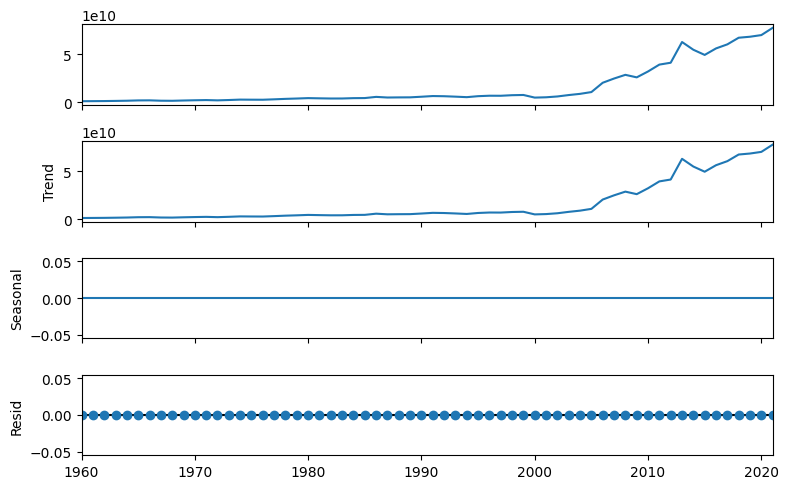

In [25]:
# декомпозиция временного ряда 
plt.rcParams["figure.figsize"] = 8, 5

decomposition = seasonal_decompose(df_interp)
fig = decomposition.plot()
plt.show()

## 2.5. Проверка ряда на стационарность, определение параметров и запуск модели

In [ ]:
train_df = df_interp['GDP (current US$)'][:len(df_interp)-3]
test_df = df_interp['GDP (current US$)'][len(df_interp)-3:]
train_df.shape, test_df.shape

((59,), (3,))

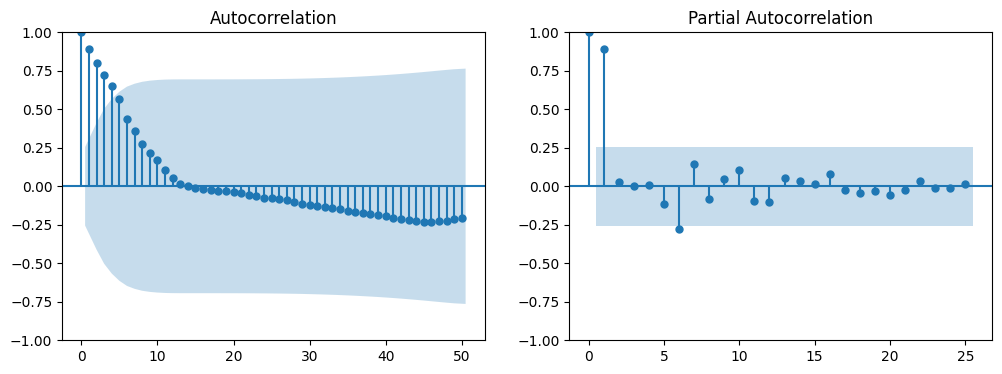

adf:  0.8030073326980115
p-value:  0.9916845572455877
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд нестационарен


In [27]:
# проверим на стационарность
plot_acf_pacf_check_adf(train_df)

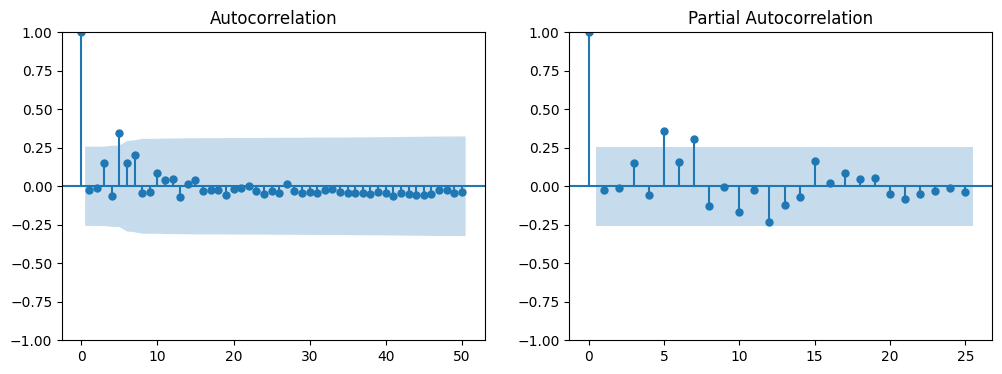

adf:  -1.8255652246436
p-value:  0.36784515276563423
Critical values:  {'1%': -3.568485864, '5%': -2.92135992, '10%': -2.5986616}
ряд нестационарен


In [28]:
# проверим на стационарность интегрированный ряд первого порядка
plot_acf_pacf_check_adf(train_df.diff().dropna())

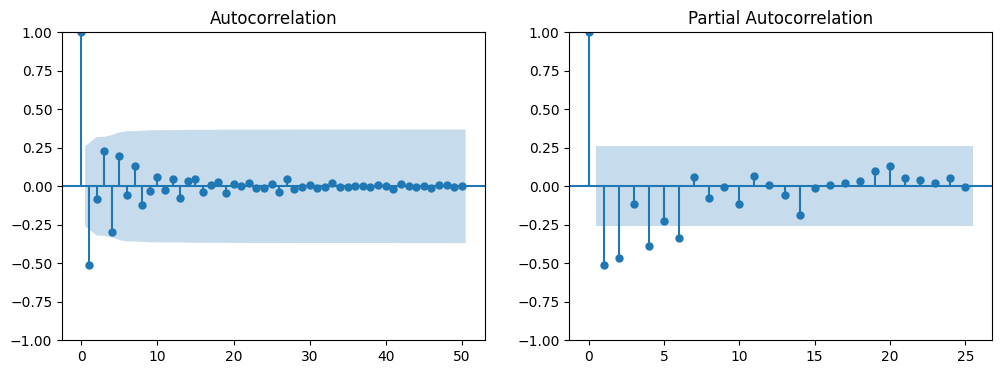

adf:  -2.63463474600784
p-value:  0.08604813722197724
Critical values:  {'1%': -3.5714715250448363, '5%': -2.922629480573571, '10%': -2.5993358475635153}
ряд нестационарен


In [29]:
# проверим на стационарность интегрированный ряд второго порядка
plot_acf_pacf_check_adf(train_df.diff().dropna().diff().dropna())

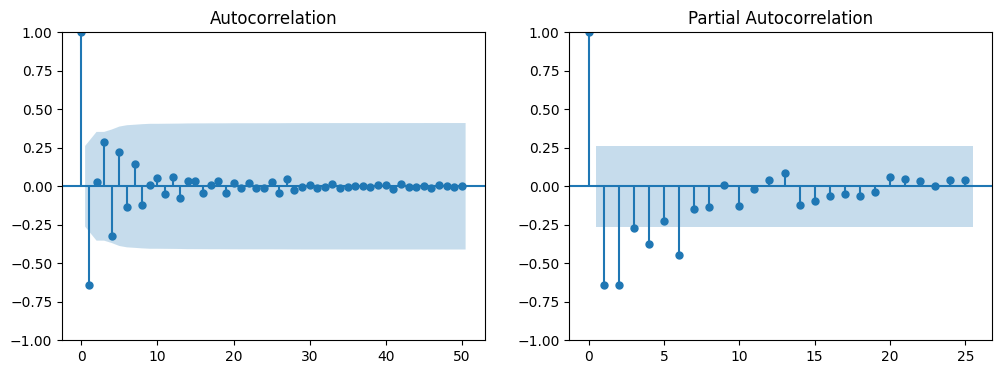

adf:  -4.825603687304043
p-value:  4.8573180767994686e-05
Critical values:  {'1%': -3.5745892596209488, '5%': -2.9239543084490744, '10%': -2.6000391840277777}
ряд стационарен


In [30]:
# проверим на стационарность интегрированный ряд третьего порядка
plot_acf_pacf_check_adf(train_df.diff().dropna().diff().dropna().diff().dropna())

In [31]:
d = 3
p = 6
q = 1

arima_model = ARIMA(train_df, order=(p, d, q))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(6, 3, 1)   Log Likelihood               -1306.477
Date:                Fri, 05 Sep 2025   AIC                           2628.955
Time:                        18:20:18   BIC                           2645.157
Sample:                    01-01-1960   HQIC                          2635.236
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3720      0.070    -19.722      0.000      -1.508      -1.236
ar.L2         -1.7152      0.151    -11.394      0.000      -2.010      -1.420
ar.L3         -1.5816      0.197     -8.016      0.000      -1.968      -1.195
ar.L4         -1.6557      0.137    -12.060      0.000      -1.925      -1.387
ar.L5         -1.2760      0.157     -8.124      0.000      -1.584      -0.968
ar.L6         -0.8916      0.141     -6.340      0.000      -1.167      -0.616
ma.L1         -0.5844      0.105     -5.583      0.000      -0.789      -0.379
sigma2      8.426e+18   3.34e-20   2.52e+38      0.000    8.43e+18    8.43e+18
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                76.24
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):             120.88   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.35e+54. Standard errors may be unstable.
"""

Значение AIC на интерполированных данных немного лучше, чем на изначальных

In [32]:
# поищем наилучшие параметры

smodel = pm.auto_arima(
    train_df,
    start_p=4, max_p=10,   # перебор p
    start_q=0, max_q=5,   # перебор q
    d=3,                  # порядок интегрирования
    start_P=0, max_P=5,   # сезонный p
    start_Q=0, max_Q=5,   # сезонный q
    D=1,                  # сезонная дифференциация
    test="adf",           # проверка на стационарность
    information_criterion="aic", # критерий выбора
    error_action="ignore",
    n_jobs=-1,            # распараллеливание
    trace=True            # выводим процесс
)

print(smodel.summary())

Performing stepwise search to minimize aic
 ARIMA(4,3,0)(0,0,0)[0]             : AIC=2663.433, Time=0.07 sec
 ARIMA(0,3,0)(0,0,0)[0]             : AIC=2734.778, Time=0.01 sec
 ARIMA(1,3,0)(0,0,0)[0]             : AIC=2707.155, Time=0.01 sec
 ARIMA(0,3,1)(0,0,0)[0]             : AIC=2682.372, Time=0.02 sec
 ARIMA(3,3,0)(0,0,0)[0]             : AIC=2676.882, Time=0.02 sec
 ARIMA(5,3,0)(0,0,0)[0]             : AIC=2662.024, Time=0.06 sec
 ARIMA(6,3,0)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(5,3,1)(0,0,0)[0]             : AIC=2646.807, Time=0.10 sec
 ARIMA(4,3,1)(0,0,0)[0]             : AIC=2647.817, Time=0.07 sec
 ARIMA(6,3,1)(0,0,0)[0]             : AIC=2628.955, Time=0.21 sec
 ARIMA(7,3,1)(0,0,0)[0]             : AIC=2626.622, Time=0.30 sec
 ARIMA(7,3,0)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(8,3,1)(0,0,0)[0]             : AIC=2628.765, Time=0.40 sec
 ARIMA(7,3,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(6,3,2)(0,0,0)[0]             : AIC=inf, T

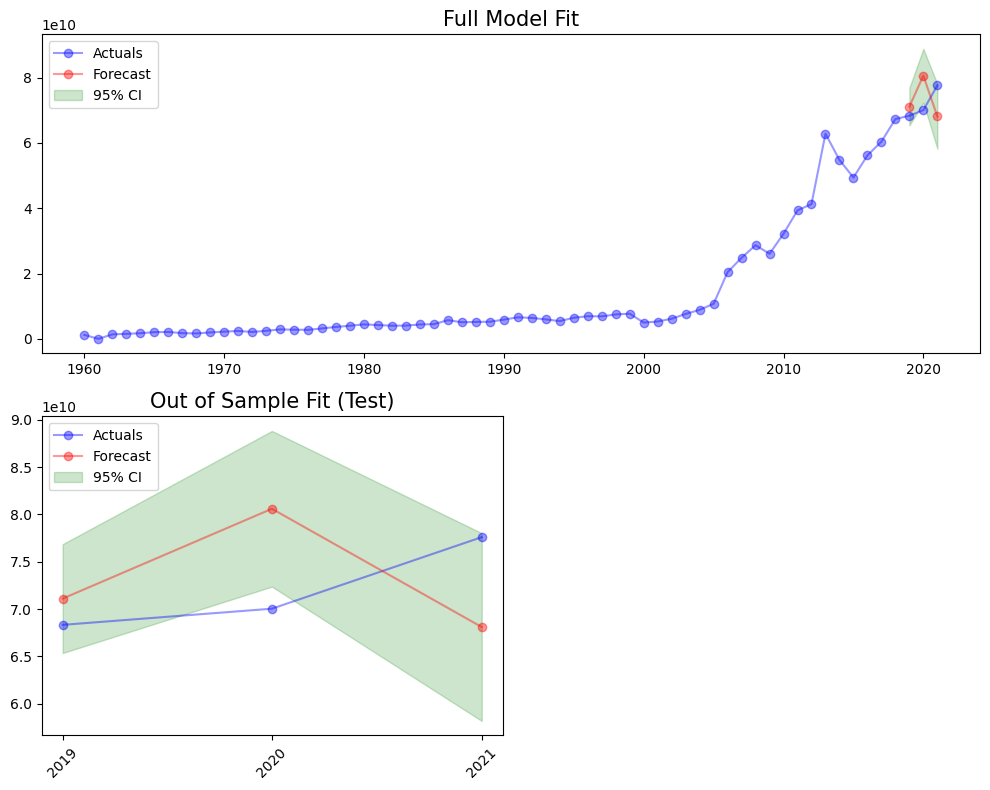

In [33]:
Final_model = SARIMAX(train_df,
                    order=smodel.order,
                    seasonal_order=smodel.seasonal_order)
Final_output = Final_model.fit(disp=False)

# Прогноз на тест
forecast = Final_output.get_forecast(steps=len(test_df))
forecast_conf = forecast.conf_int(alpha=0.05)

# Собираем DataFrame с предсказаниями
pred_df = pd.DataFrame({
    "actuals": data["GDP (current US$)"],
    "model_preds": forecast.predicted_mean,
    "model_preds_lower": forecast_conf.iloc[:, 0],
    "model_preds_upper": forecast_conf.iloc[:, 1]
})

# Визуализация
plt.rcParams["figure.figsize"] = (10, 8)

# --- График 1: полный ряд ---
plt.subplot(2, 1, 1)
plt.plot(pred_df["actuals"], color="blue", label="Actuals", alpha=0.4, marker='o')
plt.plot(pred_df["model_preds"], color="red", label="Forecast", alpha=0.4, marker='o')

plt.fill_between(
    forecast_conf.index,
    forecast_conf.iloc[:, 0],
    forecast_conf.iloc[:, 1],
    color="green",
    alpha=0.2,
    label="95% CI"
)
plt.title("Full Model Fit", size=15)
plt.legend()

# --- График 2: тестовый участок ---
plt.subplot(2, 2, 3)
plt.plot(test_df.index, test_df.values, color="blue", label="Actuals", alpha=0.4, marker='o')
plt.plot(test_df.index, forecast.predicted_mean, color="red", label="Forecast", alpha=0.4, marker='o')
plt.fill_between(
    forecast_conf.index,
    forecast_conf.iloc[:, 0],
    forecast_conf.iloc[:, 1],
    color="green",
    alpha=0.2,
    label="95% CI"
)
plt.title("Out of Sample Fit (Test)", size=15)
plt.legend()

# Настройка оси X для годовых данных
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # каждая метка — год
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # отображать только год
plt.xticks(rotation=45)  # повернуть метки для читаемости

plt.tight_layout()
plt.show()

## 2.6. Анализ полученного AIC критерия построенной модели по сравнению с моделью на неинтерполированных данных. Выводы

Значение AIC на интерполированных данных немного улучшилось, наилучшие параметры для модели остались те же, предсказание стало чуть ближе к доверительному интервалу

# 3. Валидация временных рядов

<img src="https://lms-cdn.skillfactory.ru/assets/courseware/v1/8016a5615b36084c9633c70a9648f8b3/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/MATHML_md13_8_4.png" alt="" width="600" align="center" />

1. Разбейте временной ряд на три набора (3 train + 3 test). Для этого воспользуйтесь классом [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html) из sklearn.model_selection с параметрами n_splits=3 и test_size=7 (или max_train_size=df.sales.count()-7). Наборы данных можно получить, вызвав метод split (временной ряд) у инициализированного TimeSeriesSplit.

Пример кода:
```py
tscv = TimeSeriesSplit(...)
```
2. Выведите размеры полученных подвыборок:
```py
train_test_groups = tscv.split(df.sales) 
for train_index, test_index in train_test_groups:
    print("TRAIN size:", len(train_index), "TEST size:", len(test_index))
```
Обратите внимание на отличие в размерах выборок на рисунке с walk forward validation и множественным разбиением. В задании вы вывели размеры полученных выборок. Какой случай вы получили?

In [34]:
# Берём восстановленный ряд (GDP)
tscv = TimeSeriesSplit(n_splits=3, test_size=7)

# Разбиения
train_test_groups = tscv.split(df_interp['GDP (current US$)'])

for i, (train_index, test_index) in enumerate(train_test_groups, 1):
    print(f"Split {i}")
    print("  TRAIN size:", len(train_index), "TEST size:", len(test_index))
    print("  TRAIN years:", df_interp.index[train_index[0]], "→", df_interp.index[train_index[-1]])
    print("  TEST  years:", df_interp.index[test_index[0]], "→", df_interp.index[test_index[-1]])
    print("-"*50)

Split 1
  TRAIN size: 41 TEST size: 7
  TRAIN years: 1960-01-01 00:00:00 → 2000-01-01 00:00:00
  TEST  years: 2001-01-01 00:00:00 → 2007-01-01 00:00:00
--------------------------------------------------
Split 2
  TRAIN size: 48 TEST size: 7
  TRAIN years: 1960-01-01 00:00:00 → 2007-01-01 00:00:00
  TEST  years: 2008-01-01 00:00:00 → 2014-01-01 00:00:00
--------------------------------------------------
Split 3
  TRAIN size: 55 TEST size: 7
  TRAIN years: 1960-01-01 00:00:00 → 2014-01-01 00:00:00
  TEST  years: 2015-01-01 00:00:00 → 2021-01-01 00:00:00
--------------------------------------------------


- Получилось 3 разбиения (так как n_splits=3).

- Каждое тестовое множество имеет 7 лет, а train постепенно «растёт».

- Это именно множестенное разбиение временного ряда, а не walk-forward (в walk-forward train фиксируется, а здесь он расширяется).

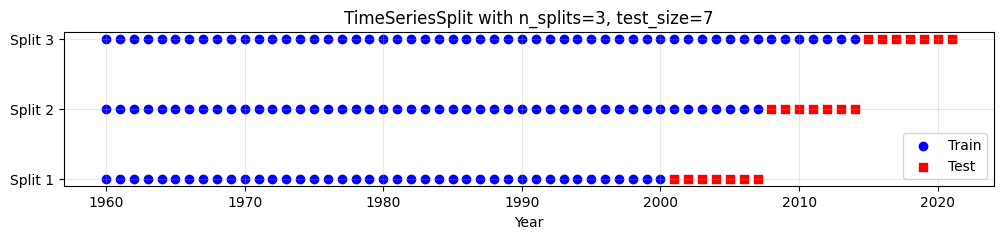

In [35]:
splits = list(tscv.split(df_interp))

# Визуализация с годами
plt.figure(figsize=(12, 2))

for i, (train_idx, test_idx) in enumerate(splits, 1):
    # Train = синие точки
    plt.scatter(df_interp.index[train_idx], [i]*len(train_idx), 
                color="blue", marker="o", label="Train" if i==1 else "")
    # Test = красные точки
    plt.scatter(df_interp.index[test_idx], [i]*len(test_idx), 
                color="red", marker="s", label="Test" if i==1 else "")

plt.yticks(range(1, len(splits)+1), [f"Split {i}" for i in range(1, len(splits)+1)])
plt.xlabel("Year")
plt.title("TimeSeriesSplit with n_splits=3, test_size=7")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# 4. Модели прогнозирования гетероскедастичности. Валидация временных рядов. Практика

**Задания для проекта**
1. Посчитайте волатильность для вашего временного ряда. 
2. Используйте GARCH-модель для предсказания волатильности. 
3. Используйте линейную регрессию для получения прогноза. 
4. Визуализируйте полученное предсказание вместе с фактическим значением. 
5. Сравните результаты и сделайте выводы. 
6. Почему результат модели GARCH получился именно таким? 

## 4.1. Подсчет волатильности для нашего временного ряда

 **Volatility** at time **t**  

$Vol(t) = |\frac{Price(t) - Price(t-1)}{Price(t-1)} * 100|$

In [36]:
df = df_interp.copy()
df["gdp_vol"] = df.pct_change(1).mul(100).abs()
df["gdp_vol"].head()

year
1960-01-01          NaN
1961-01-01     6.789413
1962-01-01     6.357759
1963-01-01    11.448835
1964-01-01    12.363636
Freq: YS-JAN, Name: gdp_vol, dtype: float64

<Axes: xlabel='year'>

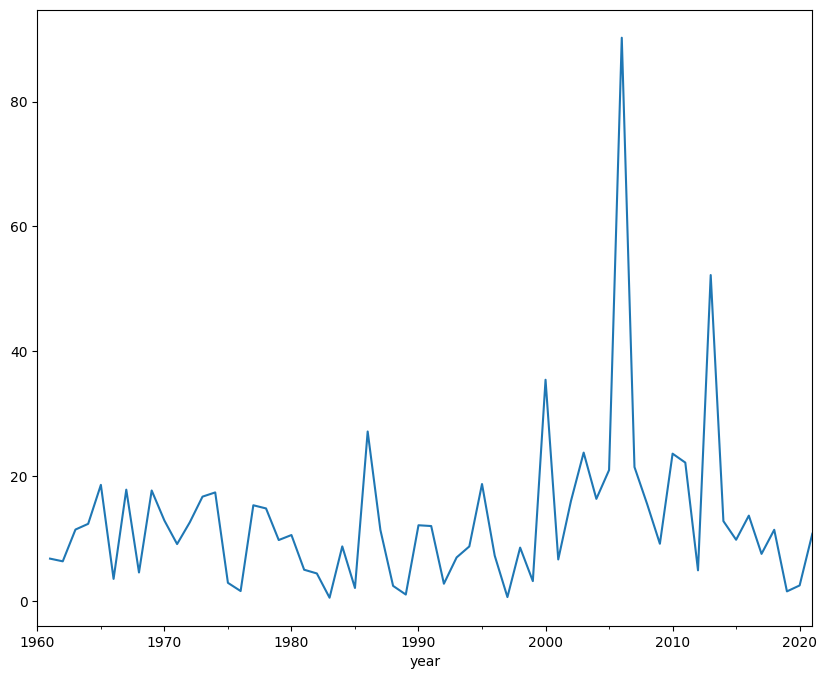

In [37]:
df["gdp_vol"].plot()

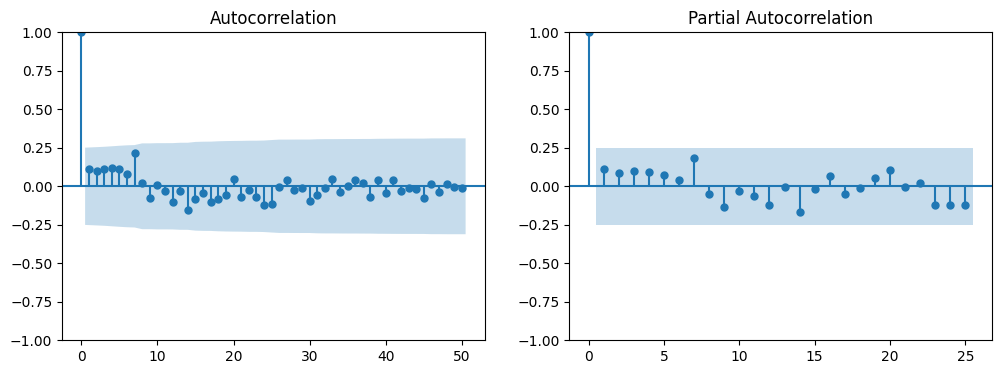

adf:  -6.80733894469635
p-value:  2.1599127900854784e-09
Critical values:  {'1%': -3.5443688564814813, '5%': -2.9110731481481484, '10%': -2.5931902777777776}
ряд стационарен


In [38]:
plot_acf_pacf_check_adf(df["gdp_vol"].dropna())

## 4.2. GARCH-модель для предсказания волатильности

Любое обращение к методу forecast() возвращает объект ARCHModelForecast с тремя основными атрибутами:

- `.mean` — условное среднее значение ряда;
- `.variance` — условная дисперсия прогноза;
- `.residual_variance` — прогнозируемая условная дисперсия остатков. Residual_variance будет отличаться от variance в случаях, когда значения ряда (не дисперсии, а именно сами значения) имеют зависимость от себя в прошлом. Для предсказания дисперсии мы используем residual_variance, если ряд стационарен и residual_variance и variance возвращают одинаковые значения.

При инициализации модели подаётся вся выборка `model = arch_model(garch_df["spx_vol"].dropna(), p=1, q=1)`. Модель не может предсказать волатильность на основе прошлых значений процентных изменений, не имея тестовой выборки. Если в такую модель подать только выборку train, метод forecast() выдаст ошибку именно из-за отсутствия тестовой выборки.

In [39]:
train_df = df[:len(df)-3]
test_df = df[len(df)-3:]
print(train_df.shape, test_df.shape)

# нам важно сохранить объем датасета, поэтому берем за исходные данные весь датасет с индексами, который содержит
# и train и test часть
garch_df = pd.DataFrame(df["gdp_vol"].loc[df.index])

# далее необходимо использовать актуальные обучающие данные, которые находятся в выборке train_df.

garch_df.loc[train_df.index, "gdp_vol"] = train_df["gdp_vol"].dropna()

model = arch_model(garch_df["gdp_vol"].dropna(), p=1, q=1)

# в параметре last_obs указываем последний объект, до которого будем совершать обучение.
# в нашем случае это до первого объекта из test выборки

model_results = model.fit(last_obs=test_df.index[0], update_freq=5)

(59, 2) (3, 2)
Iteration:      5,   Func. Count:     27,   Neg. LLF: 251.18811047858395
Iteration:     10,   Func. Count:     57,   Neg. LLF: 4522.5403032525255
Iteration:     15,   Func. Count:     89,   Neg. LLF: 228.00251345130135
Iteration:     20,   Func. Count:    114,   Neg. LLF: 226.5978293605918
Optimization terminated successfully    (Exit mode 0)
            Current function value: 226.59781233106128
            Iterations: 22
            Function evaluations: 123
            Gradient evaluations: 22


In [40]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                gdp_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -226.598
Distribution:                  Normal   AIC:                           461.196
Method:            Maximum Likelihood   BIC:                           469.437
                                        No. Observations:                   58
Date:                Fri, Sep 05 2025   Df Residuals:                       57
Time:                        18:20:23   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            12.3191      2.572      4.790  1.666e-06 [  7.279, 17.360]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          3.6700     24.738      0.148      0.882 [-44.817, 52.157]
alpha[1]   6.0947e-11  9.201e-02  6.624e-10      1.000 [ -0.180,  0.180]
beta[1]        1.0000      0.157      6.384  1.725e-10 [  0.693,  1.307]
========================================================================

Covariance estimator: robust
"""

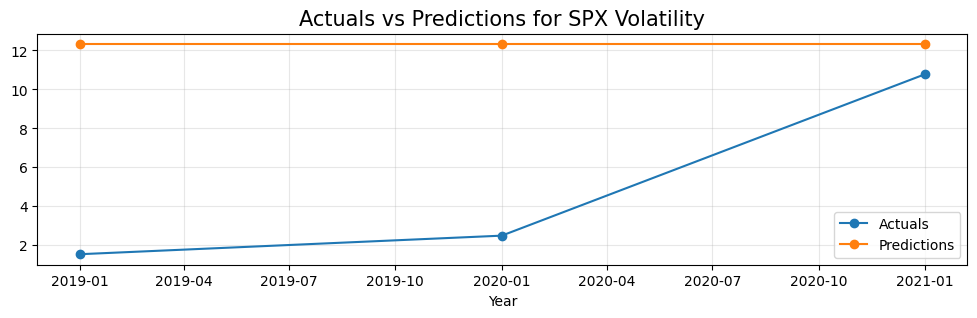

In [41]:
predictions_df = test_df.copy()

predictions_df["Predictions"] = model_results.forecast(horizon=len(test_df)).mean["h.1"].loc[test_df.index]

plt.rcParams["figure.figsize"] = 12, 3

plt.plot(predictions_df["gdp_vol"].abs(), label="Actuals", marker='o')
plt.plot(predictions_df["Predictions"], label="Predictions", marker='o')

plt.xlabel("Year")
plt.title("Actuals vs Predictions for SPX Volatility", size=15)
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [42]:
mean_squared_error(
    predictions_df["gdp_vol"].abs(), predictions_df["Predictions"]
)

71.66444334084592

## 4.3. Линейная регрессия для получения прогноза

In [43]:
X_train = pd.DataFrame(range(df["gdp_vol"].shape[0]))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(df["gdp_vol"].shape[0]))[
    train_df.shape[0] :
].fillna(0)
y_train = train_df["gdp_vol"].fillna(0)
y_test = test_df["gdp_vol"].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)

mean_squared_error(
    y_test, lr_predict
)

251.4089377647131

## 4.4. Визуализация полученного предсказания вместе с фактическим значением

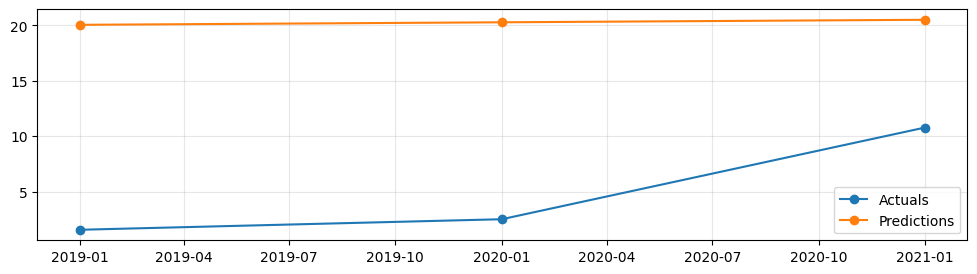

In [44]:
plt.plot(y_test, label="Actuals", marker='o')
plt.plot(pd.Series(lr_predict, index=y_test.index), label="Predictions", marker='o')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 4.5. Сравнение результатов и выводы

Среднеквадратичная ошибка предсказания для модели GARCH (72) меньше, чем для линейной модели (251)

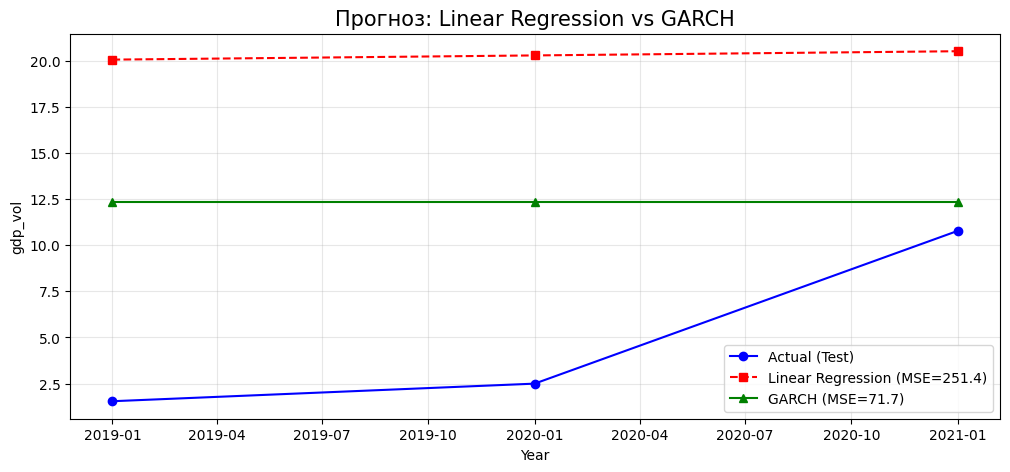

In [45]:
# Предсказания
lr_pred = lr.predict(X_test)  
garch_pred = model_results.forecast(horizon=len(test_df)).mean["h.1"].loc[test_df.index]

# Ошибки
mse_lr = mean_squared_error(y_test, lr_pred)
mse_garch = mean_squared_error(y_test, garch_pred)

# Визуализация
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test, marker='o', color='blue', label="Actual (Test)")
plt.plot(y_test.index, lr_pred, marker='s', linestyle='--', color='red', label=f"Linear Regression (MSE={mse_lr:.1f})")
plt.plot(y_test.index, garch_pred, marker='^', linestyle='-', color='green', label=f"GARCH (MSE={mse_garch:.1f})")

plt.title("Прогноз: Linear Regression vs GARCH", size=15)
plt.xlabel("Year")
plt.ylabel("gdp_vol")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## 4.6. Почему результат модели GARCH получился именно таким?

---

* Линейная регрессия получает на вход **индекс времени** (0,1,2,…) → она фактически строит **прямую линию** (тренд).
* Линейная регрессия не учитывает ни сезонности, ни автокорреляции, ни изменчивость дисперсии.
* Поэтому у неё ошибка достаточно велика (251).

---

* Модель GARCH умеет описывать:

  * **среднее значение ряда** (авторегрессия),
  * **волатильность** (меняющуюся дисперсию остатков).
* Если ряд действительно имеет **автокорреляцию и гетероскедастичность** (например, периоды «спокойных» и «бурных» колебаний), GARCH подстраивается под это.
* В результате прогноз получается ближе к реальным значениям, MSE меньше.

---

* У линейной модели MSE ≈ **251**, потому что она «усредняет» всё трендом и не ловит динамику.
* У GARCH MSE ≈ **72**, потому что:

  * она учитывает **структуру зависимостей во времени** (авторегрессию),
  * и подстраивает прогноз под текущую **волатильность** (т.е. предсказывает, когда значения будут более изменчивыми).
* То есть GARCH оказалась лучше, потому что её предположения ближе к природе временного ряда `gdp_vol`.

---

✅ Вывод:
Модель GARCH показывает меньшую ошибку, потому что умеет учитывать **автокорреляцию и изменяющуюся волатильность** во временном ряду, чего не может простая линейная регрессия по индексу.

---

# 5. Моделирование с Prophet

18:20:24 - cmdstanpy - INFO - Chain [1] start processing
18:20:24 - cmdstanpy - INFO - Chain [1] done processing


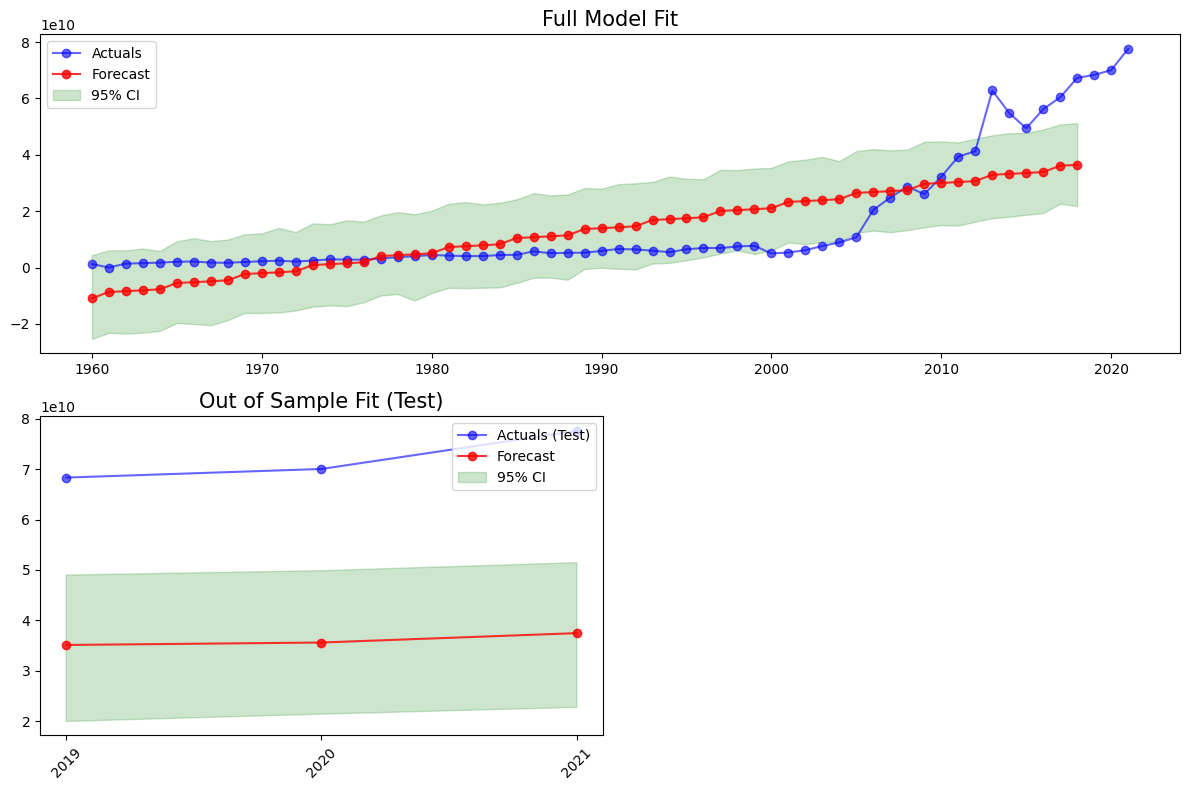

In [46]:
data = pd.read_csv("data/ghana_gdp.csv", parse_dates=["year"], index_col=["year"])
df = data.asfreq("AS")

# Интерполяция пропусков
df["GDP (current US$)"] = df["GDP (current US$)"].interpolate(method="linear")

# Prophet требует колонки ds и y
df_prophet = df.reset_index().rename(
    columns={"year": "ds", "GDP (current US$)": "y"}
)

train_df = df_prophet[:len(df_prophet)-3]
test_df = df_prophet[len(df_prophet)-3:]

# Создаем модель Prophet
m = Prophet()

# Обучаем модель на наших данных
m.fit(train_df)

# Прогноз на 3 года вперёд
future = m.make_future_dataframe(periods=3, freq="Y")
forecast = m.predict(future)

# Объединяем фактические и прогнозные значения
pred_df = df_prophet.set_index("ds").copy()
pred_df["yhat"] = forecast.set_index("ds")["yhat"]
pred_df["yhat_lower"] = forecast.set_index("ds")["yhat_lower"]
pred_df["yhat_upper"] = forecast.set_index("ds")["yhat_upper"]

# --- Визуализация ---
plt.rcParams["figure.figsize"] = (12, 8)

# График 1: полный ряд
plt.subplot(2, 1, 1)
plt.plot(pred_df.index, pred_df["y"], color="blue", label="Actuals", alpha=0.6, marker='o')
plt.plot(pred_df.index, pred_df["yhat"], color="red", label="Forecast", alpha=0.8, marker='o')
plt.fill_between(
    pred_df.index,
    pred_df["yhat_lower"],
    pred_df["yhat_upper"],
    color="green", alpha=0.2, label="95% CI"
)
plt.title("Full Model Fit", size=15)
plt.legend()

# График 2: тестовый участок
plt.subplot(2, 2, 3)
plt.plot(test_df["ds"], test_df["y"], color="blue", label="Actuals (Test)", alpha=0.6, marker='o')
plt.plot(test_df["ds"], forecast.tail(3)["yhat"], color="red", label="Forecast", alpha=0.8, marker='o')
plt.fill_between(
    forecast.tail(3)["ds"],
    forecast.tail(3)["yhat_lower"],
    forecast.tail(3)["yhat_upper"],
    color="green", alpha=0.2, label="95% CI"
)
plt.title("Out of Sample Fit (Test)", size=15)
plt.legend()

# Настройка оси X (годовые данные)
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Как видим,  Prophet не учитывает волатильность и предсказания далеки от реальных значений